In [1]:
!wget --no-check-certificate \
     https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip \
     -O /tmp/glove.840B.300d.zip

--2024-02-16 03:42:03--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
Resolving huggingface.co (huggingface.co)... 18.161.21.22, 18.161.21.44, 18.161.21.41, ...
Connecting to huggingface.co (huggingface.co)|18.161.21.22|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/f47355dd5b267bd10f08671e513790690233c76a9ffd73aa915d78f894a8912e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.840B.300d.zip%3B+filename%3D%22glove.840B.300d.zip%22%3B&response-content-type=application%2Fzip&Expires=1708314123&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODMxNDEyM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS9mNDczNTVkZDViMjY3YmQxMGYwODY3MWU1MTM3OTA2OTAyMzNjNzZhOWZmZDczYWE5MTVkNzhmODk0YTg5MTJlP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=y-ELGplt

In [2]:
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.840B.300d.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [4]:
import tensorflow as tf

In [5]:
from keras import utils
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout, Embedding, BatchNormalization, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data

In [6]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm
import numpy as np

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
def sentence2vector(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if w not in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    else:
        return v / np.sqrt((v ** 2).sum())

In [9]:
with open('ebert_test_train_data.pkl', 'rb') as f:
    train_data, test_data = pickle.load(f)

In [10]:
os.listdir('/tmp/glove')

['glove.840B.300d.txt']

In [11]:
train_data, valid_data = train_test_split(train_data, stratify=train_data['stars'], test_size=0.1, random_state=42)

X_train = train_data['review']
y_train = train_data['stars']
X_valid = valid_data['review']
y_valid = valid_data['stars']
X_test = test_data['review']
y_test = test_data['stars']

print(len(X_train), len(y_train), len(X_valid), len(y_valid), len(X_test), len(y_test))

lbl_enc = preprocessing.LabelEncoder()
y_encoded = lbl_enc.fit_transform(list(y_train) + list(y_valid) + list(y_test))
y_train_enc = y_encoded[0:len(y_train)]
y_valid_enc = y_encoded[len(y_train):len(y_train) + len(y_valid)]
y_test_enc = y_encoded[len(y_train) + len(y_valid):len(y_train) + len(y_valid) + len(y_test)]

# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_valid))
xtrain_tfv =  tfv.transform(X_train) 
xvalid_tfv = tfv.transform(X_valid)

5204 5204 579 579 1928 1928


In [12]:
# from http://www-nlp.stanford.edu/data/glove.840B.300d.zip

embeddings_index = {}
missed_values = []
with open('/tmp/glove/glove.840B.300d.txt') as f:
    i = 0
    for line in tqdm(f):
        try:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except Exception as e:
            missed_values.append(values)
        i += 1
        
print("Found %s words vectors" % len(embeddings_index))

x_train_glove = [sentence2vector(x) for x in X_train]
x_valid_glove = [sentence2vector(x) for x in X_valid]

x_train_glove = np.array(x_train_glove)
x_valid_glove = np.array(x_valid_glove)

2196018it [01:28, 24705.19it/s]


Found 2195885 words vectors


# Tokenize

In [13]:
from keras.preprocessing import sequence, text
from keras.utils import pad_sequences

# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(X_train) + list(X_valid))
x_train_seq = token.texts_to_sequences(X_train)
x_valid_seq = token.texts_to_sequences(X_valid)

# zero pad the sequences
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = pad_sequences(x_valid_seq, maxlen=max_len)

word_index = token.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 85752/85752 [00:00<00:00, 390134.38it/s]


# Word Count

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train) + list(X_valid))
xtrain_ctv =  ctv.transform(X_train) 
xvalid_ctv = ctv.transform(X_valid)

# GPU

In [24]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.sysconfig.get_build_info(), tf.sysconfig.get_build_info()["cuda_version"]

Num GPUs Available:  1


(OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
              ('cuda_compute_capabilities',
               ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
              ('cuda_version', '11.2'),
              ('cudnn_version', '8'),
              ('is_cuda_build', True),
              ('is_rocm_build', False),
              ('is_tensorrt_build', True)]),
 '11.2')

In [25]:
# suppress info and warnings outputted by tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# enable memory growth for gpu devices
# source: https://stackoverflow.com/a/55541385/8849692
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)

# One-Way LSTM

In [106]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(512, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(9))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [99]:
checkpoint_path = "one_way_lstm_10/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [100]:
y_train_enc.shape, np.unique(y_train_enc)

((4214,), array([0, 1, 2, 3, 4, 5, 6, 7, 8]))

In [101]:
np.array([[1 if i == y else 0 for i in range(9)] for y in y_train_enc])[:5], y_train_enc[:5], np.array([[1 if i == y else 0 for i in range(9)] for y in y_train_enc]).shape

(array([[0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0]]),
 array([6, 4, 7, 6, 7]),
 (4214, 9))

In [102]:
np.array([[1 if i == y else 0 for i in range(9)] for y in y_valid_enc])[:5], y_valid_enc[:5], np.array([[1 if i == y else 0 for i in range(9)] for y in y_valid_enc]).shape

(array([[0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0]]),
 array([6, 4, 6, 8, 6]),
 (469, 9))

In [103]:
x_train_pad.shape, x_valid_pad.shape, y_train_enc.shape, y_valid_enc.shape

((4214, 70), (469, 70), (4214,), (469,))

In [104]:
model.fit(
    x_train_pad, 
    y=np.array([[1 if i == y else 0 for i in range(9)] for y in y_train_enc]), 
    batch_size=128, 
    epochs=100, 
    verbose=1, 
    validation_data=(
        x_valid_pad,
        np.array([[1 if i == y else 0 for i in range(9)] for y in y_valid_enc]),
    ),
    callbacks=[cp_callback, earlystop]
)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 2.4282
Epoch 1: saving model to one_way_lstm_10/cp.ckpt
33/33 [==============================] - 64s 2s/step - loss: 2.4282 - val_loss: 2.1655
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 2.0103
Epoch 2: saving model to one_way_lstm_10/cp.ckpt
33/33 [==============================] - 53s 2s/step - loss: 2.0103 - val_loss: 2.1289
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 1.9792
Epoch 3: saving model to one_way_lstm_10/cp.ckpt
33/33 [==============================] - 52s 2s/step - loss: 1.9792 - val_loss: 2.1008
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 1.9585
Epoch 4: saving model to one_way_lstm_10/cp.ckpt
33/33 [==============================] - 52s 2s/step - loss: 1.9585 - val_loss: 2.0741
Epoch 5/100
33/33 [==============================] - ETA: 0s - loss: 1.9484
Epoch 5: saving model to one_way_lstm_10/cp.ckpt
33/33 [====================

# Bi-directional LSTM

In [20]:
checkpoint_path = "bidirectional_lstm_v2/cp.ckpt"

# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(9))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(
    x_train_pad, 
    y=np.array([[1 if i == y else 0 for i in range(9)] for y in y_train_enc]), 
    batch_size=512, 
    epochs=100, 
    verbose=1, 
    validation_data=(
        x_valid_pad, 
        np.array([[1 if i == y else 0 for i in range(9)] for y in y_valid_enc])
    ), 
    callbacks=[earlystop, cp_callback])

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 5.1043
Epoch 1: saving model to bidirectional_lstm_v2/cp.ckpt
11/11 [==============================] - 24s 1s/step - loss: 5.1043 - val_loss: 2.1806
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 2.1599
Epoch 2: saving model to bidirectional_lstm_v2/cp.ckpt
11/11 [==============================] - 13s 1s/step - loss: 2.1599 - val_loss: 2.1622
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 2.0935
Epoch 3: saving model to bidirectional_lstm_v2/cp.ckpt
11/11 [==============================] - 13s 1s/step - loss: 2.0935 - val_loss: 2.1418
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 2.0721
Epoch 4: saving model to bidirectional_lstm_v2/cp.ckpt
11/11 [==============================] - 14s 1s/step - loss: 2.0721 - val_loss: 2.1223
Epoch 5/100
11/11 [==============================] - ETA: 0s - loss: 2.0387
Epoch 5: saving model to bidirectional_lstm_v2/cp.ck

In [21]:
x_test_seq = token.texts_to_sequences(X_test)

# zero pad the sequences
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)
preds = model.predict(x_test_pad)

61/61 [==============================] - 8s 116ms/step


In [24]:
preds.shape, y_test_enc.shape, np.array([[1 if i == y else 0 for i in range(9)] for y in y_test_enc]).shape

((1928, 9), (1928,), (1928, 9))

In [26]:
preds[:5], np.array([[1 if i == y else 0 for i in range(9)] for y in y_test_enc])[:5]

(array([[0.01516627, 0.01370092, 0.05284544, 0.05781486, 0.15549056,
         0.11159503, 0.28359243, 0.1587069 , 0.15108754],
        [0.01516633, 0.01370093, 0.05284537, 0.05781493, 0.1554904 ,
         0.11159496, 0.28359234, 0.15870722, 0.15108754],
        [0.0151663 , 0.0137009 , 0.0528453 , 0.05781491, 0.15549032,
         0.11159497, 0.28359234, 0.15870728, 0.15108767],
        [0.01516633, 0.01370096, 0.05284537, 0.05781493, 0.15549053,
         0.111595  , 0.28359237, 0.15870701, 0.15108752],
        [0.01516617, 0.01370084, 0.05284537, 0.05781484, 0.15549052,
         0.11159489, 0.2835927 , 0.15870695, 0.15108769]], dtype=float32),
 array([[0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0]]))

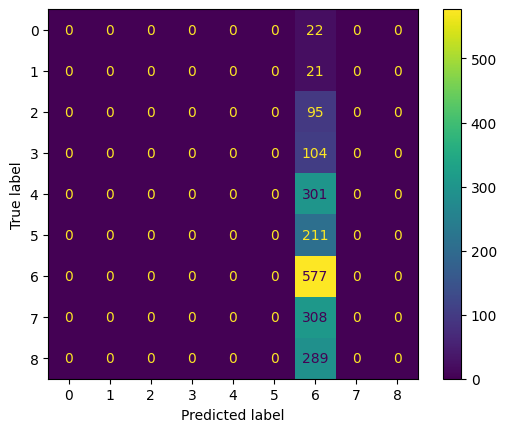

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

m = tf.math.confusion_matrix(
    y_test_enc,
    tf.argmax(input=preds, axis=1),
)

ConfusionMatrixDisplay.from_predictions(y_test_enc, tf.argmax(input=preds, axis=1))

In [34]:
model.save('bidirectional_lstm_10.keras')

# GRU

In [35]:
checkpoint_path = "gru_10/cp.ckpt"

# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(9))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(x_train_pad, 
          y=np.array([[1 if i == y else 0 for i in range(9)] for y in y_train_enc]),
          batch_size=512, epochs=100, 
          verbose=1, 
          validation_data=(
              x_valid_pad, 
              np.array([[1 if i == y else 0 for i in range(9)] for y in y_valid_enc])
          ), 
          callbacks=[earlystop, cp_callback])

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 3.5776
Epoch 1: saving model to gru_10/cp.ckpt
11/11 [==============================] - 16s 861ms/step - loss: 3.5776 - val_loss: 2.1830
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 2.0537
Epoch 2: saving model to gru_10/cp.ckpt
11/11 [==============================] - 9s 815ms/step - loss: 2.0537 - val_loss: 2.1702
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 2.0105
Epoch 3: saving model to gru_10/cp.ckpt
11/11 [==============================] - 9s 783ms/step - loss: 2.0105 - val_loss: 2.1525
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 2.0022
Epoch 4: saving model to gru_10/cp.ckpt
11/11 [==============================] - 9s 792ms/step - loss: 2.0022 - val_loss: 2.1357
Epoch 5/100
11/11 [==============================] - ETA: 0s - loss: 1.9810
Epoch 5: saving model to gru_10/cp.ckpt
11/11 [==============================] - 9s 790ms/step - loss: 

61/61 [==============================] - 6s 83ms/step


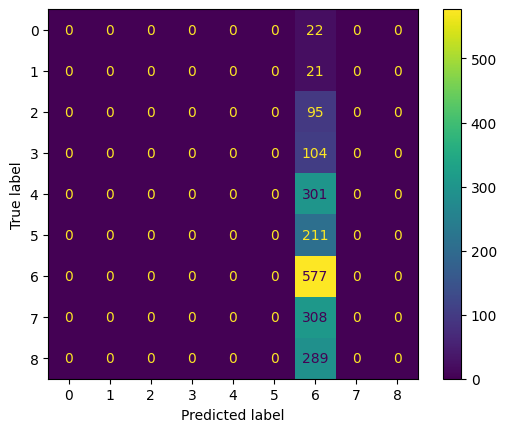

In [36]:
preds = model.predict(x_test_pad)

from sklearn.metrics import ConfusionMatrixDisplay

m = tf.math.confusion_matrix(
    y_test_enc,
    tf.argmax(input=preds, axis=1),
)

ConfusionMatrixDisplay.from_predictions(y_test_enc, tf.argmax(input=preds, axis=1))

In [37]:
model.save('gru_10.keras')

# Ensembling

In [59]:
# this is the main ensembling class. how to use it is in the next cell!
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
import os
import sys
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s %(message)s",
    datefmt="%H:%M:%S", stream=sys.stdout)
logger = logging.getLogger(__name__)


class Ensembler(object):
    def __init__(self, model_dict, num_folds=3, task_type='classification', optimize=roc_auc_score,
                 lower_is_better=False, save_path=None):
        """
        Ensembler init function
        :param model_dict: model dictionary, see README for its format
        :param num_folds: the number of folds for ensembling
        :param task_type: classification or regression
        :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
        :param lower_is_better: is lower value of optimization function better or higher
        :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
        """

        self.model_dict = model_dict
        self.levels = len(self.model_dict)
        self.num_folds = num_folds
        self.task_type = task_type
        self.optimize = optimize
        self.lower_is_better = lower_is_better
        self.save_path = save_path

        self.training_data = None
        self.test_data = None
        self.y = None
        self.lbl_enc = None
        self.y_enc = None
        self.train_prediction_dict = None
        self.test_prediction_dict = None
        self.num_classes = None

    def fit(self, training_data, y, lentrain):
        """
        :param training_data: training data in tabular format
        :param y: binary, multi-class or regression
        :return: chain of models to be used in prediction
        """

        self.training_data = training_data
        self.y = y

        if self.task_type == 'classification':
            self.num_classes = len(np.unique(self.y))
            logger.info("Found %d classes", self.num_classes)
            self.lbl_enc = LabelEncoder()
            self.y_enc = self.lbl_enc.fit_transform(self.y)
            kf = StratifiedKFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, self.num_classes)
        else:
            self.num_classes = -1
            self.y_enc = self.y
            kf = KFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, 1)

        self.train_prediction_dict = {}
        for level in range(self.levels):
            self.train_prediction_dict[level] = np.zeros((train_prediction_shape[0],
                                                          train_prediction_shape[1] * len(self.model_dict[level])))

        for level in range(self.levels):

            if level == 0:
                temp_train = self.training_data
            else:
                temp_train = self.train_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):
                validation_scores = []
                foldnum = 1
                for train_index, valid_index in kf.split(self.train_prediction_dict[0], self.y_enc):
                    logger.info("Training Level %d Fold # %d. Model # %d", level, foldnum, model_num)

                    if level != 0:
                        l_training_data = temp_train[train_index]
                        l_validation_data = temp_train[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])
                    else:
                        l0_training_data = temp_train[0][model_num]
                        if type(l0_training_data) == list:
                            l_training_data = [x[train_index] for x in l0_training_data]
                            l_validation_data = [x[valid_index] for x in l0_training_data]
                        else:
                            l_training_data = l0_training_data[train_index]
                            l_validation_data = l0_training_data[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])

                    logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

                    if self.task_type == 'classification':
                        temp_train_predictions = model.predict_proba(l_validation_data)
                        self.train_prediction_dict[level][valid_index,
                        (model_num * self.num_classes):(model_num * self.num_classes) +
                                                       self.num_classes] = temp_train_predictions

                    else:
                        temp_train_predictions = model.predict(l_validation_data)
                        self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
                    validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
                    validation_scores.append(validation_score)
                    logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
                                validation_score)
                    foldnum += 1
                avg_score = np.mean(validation_scores)
                std_score = np.std(validation_scores)
                logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
                            avg_score, std_score)

            logger.info("Saving predictions for level # %d", level)
            train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
            train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
                                        index=False, header=None)

        return self.train_prediction_dict

    def predict(self, test_data, lentest):
        self.test_data = test_data
        if self.task_type == 'classification':
            test_prediction_shape = (lentest, self.num_classes)
        else:
            test_prediction_shape = (lentest, 1)

        self.test_prediction_dict = {}
        for level in range(self.levels):
            self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
                                                         test_prediction_shape[1] * len(self.model_dict[level])))
        self.test_data = test_data
        for level in range(self.levels):
            if level == 0:
                temp_train = self.training_data
                temp_test = self.test_data
            else:
                temp_train = self.train_prediction_dict[level - 1]
                temp_test = self.test_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):

                logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
                if level == 0:
                    model.fit(temp_train[0][model_num], self.y_enc)
                else:
                    model.fit(temp_train, self.y_enc)

                logger.info("Predicting Test Level %d. Model # %d", level, model_num)

                if self.task_type == 'classification':
                    if level == 0:
                        temp_test_predictions = model.predict_proba(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict_proba(temp_test)
                    self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
                                                                                        self.num_classes] = temp_test_predictions

                else:
                    if level == 0:
                        temp_test_predictions = model.predict(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict(temp_test)
                    self.test_prediction_dict[level][:, model_num] = temp_test_predictions

            test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
            test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
                                       index=False, header=None)

        return self.test_prediction_dict

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from nep_loss import multiclass_logloss
from sklearn.metrics import accuracy_score

In [61]:
# specify the data to be used for every level of ensembling:
train_data_dict = {0: [xtrain_tfv, xtrain_ctv, xtrain_tfv, xtrain_ctv], 1: [x_train_glove]}
test_data_dict = {0: [xvalid_tfv, xvalid_ctv, xvalid_tfv, xvalid_ctv], 1: [x_valid_glove]}

model_dict = {0: [LogisticRegression(), LogisticRegression(), MultinomialNB(alpha=0.1), MultinomialNB()],

              1: [xgb.XGBClassifier(silent=True, n_estimators=120, max_depth=7)]}

ens = Ensembler(model_dict=model_dict, num_folds=3, task_type='classification',
                optimize=multiclass_logloss, lower_is_better=True, save_path='')

ens.fit(train_data_dict, y_train, lentrain=x_train_glove.shape[0])
preds = ens.predict(test_data_dict, lentest=x_valid_glove.shape[0])

NameError: name 'x' is not defined